# Mini Project2


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests

In [2]:
url_dict = {
     'data.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/data.csv',
     'movies.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/movies.csv',
     'train.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/train.csv',
     'test.csv': 'https://caltech-cs155.s3.us-east-2.amazonaws.com/sets/miniprojects/project2/data/test.csv'
}

def download_file(file_path):
    url = url_dict[file_path]
    print('Start downloading...')
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(file_path, 'wb') as f:
            for chunk in r.iter_content(chunk_size=1024 * 1024 * 1024):
                f.write(chunk)
    print('Complete')

download_file('data.csv')
download_file('movies.csv')
download_file('train.csv')
download_file('test.csv')

Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete
Start downloading...
Complete


In [3]:
def grad_U(Ui, Yij, Vj, ai, bj, mu, reg, eta):
    """
    Takes as input Ui (the ith row of U), a training point Yij, the column
    vector Vj (jth column of V^T), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Ui multiplied by eta.
    """
    
    grad = reg*Ui - Vj * ((Yij-mu) - np.dot(Ui,Vj) - ai - bj)

    foo = eta*grad

    return foo
        

def grad_V(Ui, Yij, Vj, ai, bj, mu, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """

    grad = reg*Vj - Ui * ((Yij-mu) - np.dot(Ui,Vj) - ai - bj)

    foo = eta*grad

    return foo

def grad_a(Ui, Yij, Vj, ai, bj, mu, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """

    grad = reg * ai - ((Yij-mu) - np.dot(Ui,Vj) - ai - bj)

    foo = eta*grad

    return foo

def grad_b(Ui, Yij, Vj, ai, bj, mu, reg, eta):
    """
    Takes as input the column vector Vj (jth column of V^T), a training point Yij,
    Ui (the ith row of U), reg (the regularization parameter lambda),
    and eta (the learning rate).

    Returns the gradient of the regularized loss function with
    respect to Vj multiplied by eta.
    """

    grad = reg * bj - ((Yij - mu) - np.dot(Ui,Vj) - ai - bj)

    foo = eta*grad

    return foo

def get_err(U, V, Y, a, b, mu, reg=0.0):
    """
    Takes as input a matrix Y of triples (i, j, Y_ij) where i is the index of a user,
    j is the index of a movie, and Y_ij is user i's rating of movie j and
    user/movie matrices U and V.

    Returns the mean regularized squared-error of predictions made by
    estimating Y_{ij} as the dot product of the ith row of U and the jth column of V^T.
    """
    # compute error w/o reg
    err = 0.0
    for (i,j,Yij) in Y:
        err += (Yij - mu - np.dot(U[i-1], V[j-1]) - a[i-1] - b[j-1])**2

    # compute regularization term
    if abs(reg) > 1e-16:
        err_reg = np.linalg.norm(U, ord='fro') ** 2 + np.linalg.norm(V, ord='fro') ** 2 + np.linalg.norm(a) + np.linalg.norm(b)
        err_tot = err + reg * err_reg
    else:
        err_tot = err;

    # divide by 2 and N
    N = Y.shape[0]
    err_tot = err_tot / 2 / N;

    return err_tot


def train_model(M, N, K, eta, reg, Y, mu, eps=0.0001, max_epochs=300):
    """
    Given a training data matrix Y containing rows (i, j, Y_ij)
    where Y_ij is user i's rating on movie j, learns an
    M x K matrix U and N x K matrix V such that rating Y_ij is approximated
    by (UV^T)_ij.

    Uses a learning rate of <eta> and regularization of <reg>. Stops after
    <max_epochs> epochs, or once the magnitude of the decrease in regularized
    MSE between epochs is smaller than a fraction <eps> of the decrease in
    MSE after the first epoch.

    Returns a tuple (U, V, err) consisting of U, V, and the unregularized MSE
    of the model.
    """

    # get initial U, V, a and b
    U = np.random.uniform(-0.5,0.5,size=(M,K)) 
    V = np.random.uniform(-0.5,0.5,size=(N,K))
    a = np.random.uniform(-0.05,0.05,size=(M,1))
    b = np.random.uniform(-0.05,0.05,size=(N,1))

    err_0 = get_err(U, V, Y, a, b, mu, reg)
    err_prev = err_0
    
    for epoch in range(max_epochs):
        j = np.random.permutation(np.array(range(Y.shape[0])))
        for i in j:

            # get Yij, Ui, Vj, ai, and bj
            Y_idx  = Y[i]
            Ui  = U[Y_idx[0]-1,:]
            Vj  = V[Y_idx[1]-1,:]
            Yij = Y_idx[2]
            ai  = a[Y_idx[0]-1]
            bj  = b[Y_idx[1]-1]

            # compute new Ui, Vj, ai, and bj
            Ui_new  = Ui - grad_U(Ui, Yij, Vj, ai, bj, mu, reg, eta)
            Vj_new  = Vj - grad_V(Ui, Yij, Vj, ai, bj, mu, reg, eta)
            ai_new  = ai - grad_a(Ui, Yij, Vj, ai, bj, mu, reg, eta)
            bj_new  = bj - grad_b(Ui, Yij, Vj, ai, bj, mu, reg, eta)

            # update Ui, Vj, ai, and bj
            U[Y_idx[0]-1,:] = Ui_new
            V[Y_idx[1]-1,:] = Vj_new
            a[Y_idx[0]-1] = ai_new
            b[Y_idx[1]-1] = bj_new

        # compute error
        err = get_err(U, V, Y, a, b, mu, reg)

        # compute initial error ratio
        if epoch == 0:
            delta = np.abs(err-err_0)
        elif np.abs(err_prev - err) < eps * delta:
            break
        
        # store previous error
        err_prev = err

    return U, V, a, b, get_err(U, V, Y, a, b, mu)

In [4]:
data = np.array(pd.read_csv('data.csv'))
movies = np.array(pd.read_csv('movies.csv'))
train = np.array(pd.read_csv('train.csv'))
test = np.array(pd.read_csv('test.csv'))

# compute mean for train data
mu_train = np.mean(train[:,2])

Factorizing with  943  users,  1682  movies.
Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.01
Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 0.1
Training model with M = 943, N = 1682, k = 20, eta = 0.03, reg = 1.0


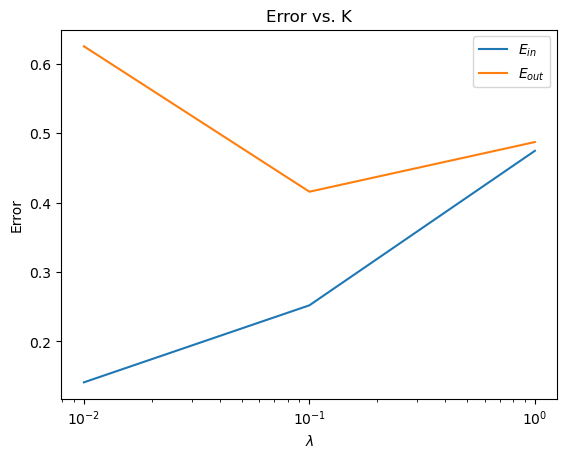

In [5]:
M = max(max(train[:,0]), max(test[:,0])).astype(int) # users
N = max(max(train[:,1]), max(test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20

regs = np.logspace(-2,0,3)
eta = 0.03 # learning rate
E_in = []
E_out = []

# Use to compute Ein and Eout
for reg in regs:
    print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, K, eta, reg))
    U,V,a,b,err = train_model(M, N, K, eta, reg, train, mu_train)
    E_in.append(err)
    E_out.append(get_err(U, V, test, a, b, mu_train))

plt.semilogx(regs, E_in, label='$E_{in}$')
plt.semilogx(regs, E_out, label='$E_{out}$')
plt.title('Error vs. K')
plt.xlabel(r'$\lambda$')
plt.ylabel('Error')
plt.legend()
plt.savefig('set5_test_bias.png')

In [54]:
M = max(max(train[:,0]), max(test[:,0])).astype(int) # users
N = max(max(train[:,1]), max(test[:,1])).astype(int) # movies
print("Factorizing with ", M, " users, ", N, " movies.")
K = 20

regs = [10**-4, 10**-3, 10**-2, 10**-1, 1]
etas = [0.001, 0.005, 0.01, 0.03, 0.05, 0.1, 0.5, 1] # learning rate
E_ins = []
E_outs = []

for eta in etas:
    E_ins_for_lambda = []
    E_outs_for_lambda = []

    for reg in regs:
        print("Training model with M = %s, N = %s, k = %s, eta = %s, reg = %s"%(M, N, K, eta, reg))
        U,V, e_in = train_model(M, N, K, eta, reg, train)
        E_ins_for_lambda.append(e_in)
        eout = get_err(U, V, test)
        E_outs_for_lambda.append(eout)

    E_ins.append(E_ins_for_lambda)
    E_outs.append(E_outs_for_lambda)


# Plot values of E_in across k for each value of lambda
for i in range(len(etas)):
    plt.semilogx(regs, E_ins[i], label='$E_{in}, \eta=$'+str(etas[i]))
plt.title('$E_{in}$ vs. $\lambda$')
plt.xlabel('$\lambda$')
plt.ylabel('Error')
plt.legend()
plt.savefig('2e_ein.png')
plt.clf()

# Plot values of E_out across k for each value of lambda
for i in range(len(regs)):
    plt.semilogx(regs, E_outs[i], label='$E_{out}, \eta=$'+str(etas[i]))
plt.title('$E_{out}$ vs. $\lambda$')
plt.xlabel('$\lambda$')
plt.ylabel('Error')
plt.legend()
plt.savefig('2e_eout.png')

Factorizing with  943  users,  1682  movies.
Training model with M = 943, N = 1682, k = 20, eta = 0.001, reg = 0.0001


TypeError: train_model() missing 1 required positional argument: 'mu'

In [ ]:
col = ['black','green','blue', 'orange','gray','red','purple','yellow']

for i in range(len(etas)):
    plt.semilogx(regs, E_ins[i], color=col[i], label='$E_{in}, \eta=$'+str(etas[i]))
    plt.semilogx(regs, E_outs[i], color=col[i], linestyle='--')
plt.title('$E$ vs. $\lambda$')
plt.xlabel('$\lambda$')
plt.ylabel('Error')
plt.legend()
plt.savefig('2e_error.png')